<a href="https://colab.research.google.com/github/joanizba/Spotifypred/blob/dev_raul/readme_raul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entorno de Desarrollo con Docker Compose (Hadoop, Cassandra, NiFi, Devbox)
Este proyecto utiliza Docker Compose para orquestar un entorno de desarrollo que incluye Apache Hadoop, Apache Cassandra, Apache NiFi, y un contenedor de desarrollo (Devbox) basado en Ubuntu.
## Servicios Incluidos

- **Hadoop:** Framework para almacenamiento distribuido y procesamiento de grandes conjuntos de datos.
- **Cassandra:** Base de datos NoSQL distribuida para grandes volúmenes de datos.
- **NiFi:** Sistema de flujo de datos robusto y fiable.
- **Devbox:** El contentenedor que hace de puerta de enlace para interactuar con los otros servicios y realizar tareas de desarrollo.

## Requisitos

- Docker: [Instalar Docker Engine](https://docs.docker.com/engine/install/)
- Docker Compose: [Instalar Docker Compose](https://docs.docker.com/compose/install/)
## Estructura del Apartado

```
.
├── docker-compose.yml
├── README.md
└── MEMORIA_TECNICA.md
```
## 🧱 1. Primer Entorno Docker (Imagen Antigua de Hadoop)
Se usó una configuración inicial con ``bde2020/hadoop-namenode:latest.``

### ▶️ Levantar el entorno
    docker-compose up -d

## **❌ Problemas frecuentes**
* NiFi no responde (http://localhost:8080/nifi)

*   Errores: ``ERR_CONNECTION_REFUSED``, ``The connection was reset.``

### Posibles causas:

* Contenedor no iniciado.

* NiFi aún arrancando.

* Firewall o falta de recursos.

### Diagnóstico

    docker ps
    docker logs nifi
    # Esperar 5-15 minutos
    # Verificar firewall

### ❗ **``apt update`` falla en el contenedor de Hadoop**
* Error: ``404 Not Found``, ``Release file not available.``

### Causa
* Repositorios obsoletos (Debian Stretch).

### Explicación
Aunque la conexión a Internet desde el contenedor funcionaba ``(ping 8.8.8.8 fue exitoso)``, los repositorios de Debian configurados en ``/etc/apt/sources.list`` de esta imagen antigua estaban desactualizados o inaccesibles en sus ubicaciones originales.
### Solución:
Editar el archivo ``sources.list`` dentro del contenedor usando ``docker cp``

    Salir del contenedor si estás dentro
    docker cp hadoop:/etc/apt/sources.list . # Copiar a tu máquina
    Editar 'sources.list' en tu máquina: comentar líneas viejas, añadir:
    deb http://archive.debian.org/debian stretch main contrib non-free
    deb-src http://archive.debian.org/debian stretch main contrib non-free
    deb http://archive.debian.org/debian-security stretch/updates main contrib non-free
    deb-src http://archive.debian.org/debian-security stretch/updates main contrib non-free
    Guardar el archivo
    docker cp sources.list hadoop:/etc/apt/sources.list # Copiar de vuelta al contenedor
    docker exec -it hadoop bash # Entrar de nuevo
    apt update # Verificar que ahora funciona
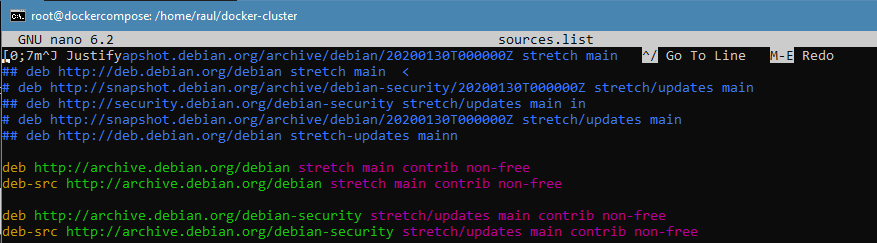

### ❗ Instalación de cqlsh falla
* Errores: ``pip: command not found``, errores de compilación, ``SyntaxError`` estilo Python 2.

### Causa
 pip no está en PATH, conflictos entre Python 2 y 3, falta de herramientas ``(build-essential, python3-dev).``

### Conclusión de errores
 #### 1.  Sistema Operativo Obsoleto dentro de la imagen de Hadoop``bde2020/hadoop-namenode:latest``.
    
1.1  Los repositorios oficiales ya no están disponibles en sus URLs originales.
    
1.2 Necesita usar archive.debian.org, lo cual implica pasos extra y seguridad reducida.
    
1.3 Algunas herramientas modernas simplemente no están disponibles o están desactualizadas.

#### 🐍 2. Python Antiguo (3.5.3)
 Python 3.5 ya no es mantenido ni compatible con muchas librerías modernas.
    
* 2.1 ``pip install cqlsh`` falla por usar sintaxis moderna no soportada en 3.5.

* 2.2 Algunas librerías como ``cassandra-driver`` requieren ``Python 3.6`` o superior.

* 2.3 ``venv`` y ``ensurepip`` no siempre están disponibles o funcionales en versiones tan antiguas.

#### 🐘 3. Incompatibilidad con Herramientas Cliente Modernas
Herramientas afectadas:

* 3.1 ``cqlsh`` (cliente de Cassandra): falla por sintaxis de Python, dependencias rotas o no disponibles.

* 3.2 ``pip``: puede no estar instalado o en el PATH correctamente.

* 3.2 ``build-essential``, ``python3-dev``: deben instalarse manualmente y muchas veces fallan por conflictos de dependencias o versiones.
### Continuidad del trabajo
Cambiar a una nueva imagen de Hadoop más actulizada en la cual no tenga incompatibilidades.

## 🧩 2. Nuevo Entorno Docker (Con Devbox)
Se adopta un nuevo archivo docker-compose.yml que incluye una imagen de Hadoop más reciente y un contenedor devbox basado en ubuntu:latest para las herramientas.

*📝 Archivo docker-compose.yml*
```text
version: '3.9'

services:
  hadoop:
    image: ghcr.io/apache/hadoop:3.3.6 # Nueva imagen de Hadoop
    container_name: hadoop
    ports:
      - "9870:9870" # WebHDFS
      - "9000:9000" # Default HDFS port
    networks:
      - my_network

  cassandra:
    image: cassandra:latest
    container_name: cassandra
    ports:
      - "9042:9042" # CQL port
    networks:
      - my_network

  nifi:
    image: apache/nifi:latest
    container_name: nifi
    ports:
      - "8080:8080" # NiFi UI
    environment:
      - NIFI_WEB_HTTP_PORT=8080
    networks:
      - my_network

  devbox: # Nuevo contenedor dedicado para herramientas
    image: ubuntu:latest # Una imagen base limpia y moderna
    container_name: devbox
    networks:
      - my_network
    stdin_open: true # Permite interactividad
    tty: true      # Asigna una TTY para una terminal interactiva

networks:
  my_network:
    driver: bridge
````
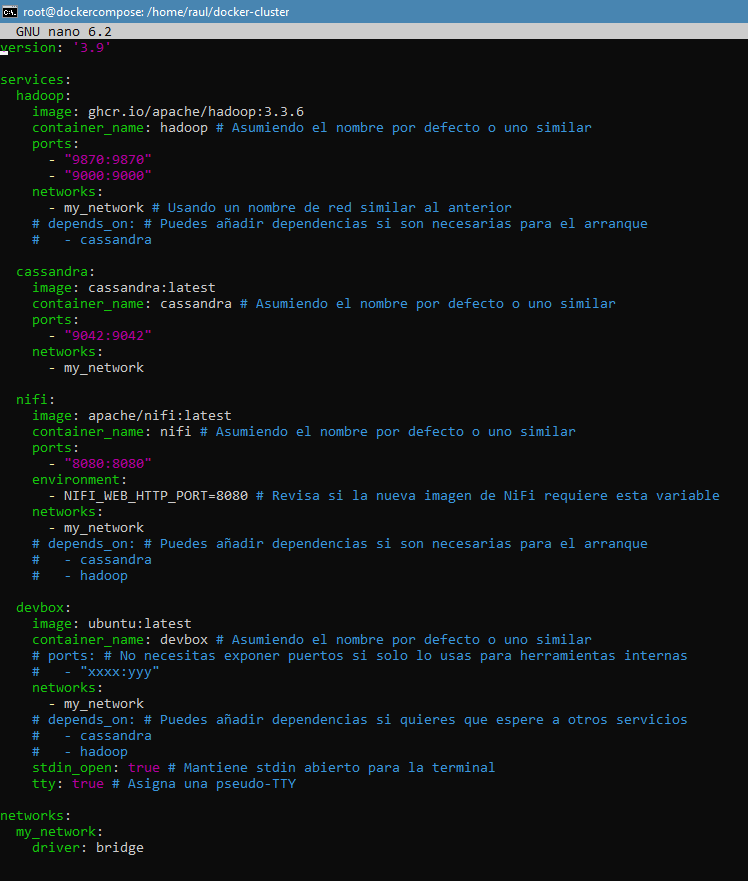
## 🧩 3. Verificación del Nuevo Entorno
Para ello tendremos que utlizar el siguiente comando;
```text
docker ps -a
````
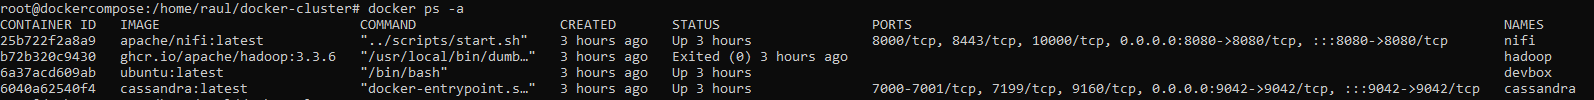

## 🧩 4. Acceder y Usar Herramientas Cliente en el Contenedor devbox
El contenedor devbox, basado en ``ubuntu:latest``, se usará para instalar y ejecutar herramientas cliente.

### 4.1  Entrar en el contenedor devbox   
    docker exec -it devbox bash
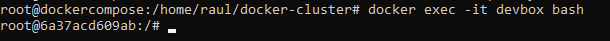

### 4.2 Actualizar listas de paquetes e instalar netcat y pip para Python 3
    apt install -y python3-pip netcat
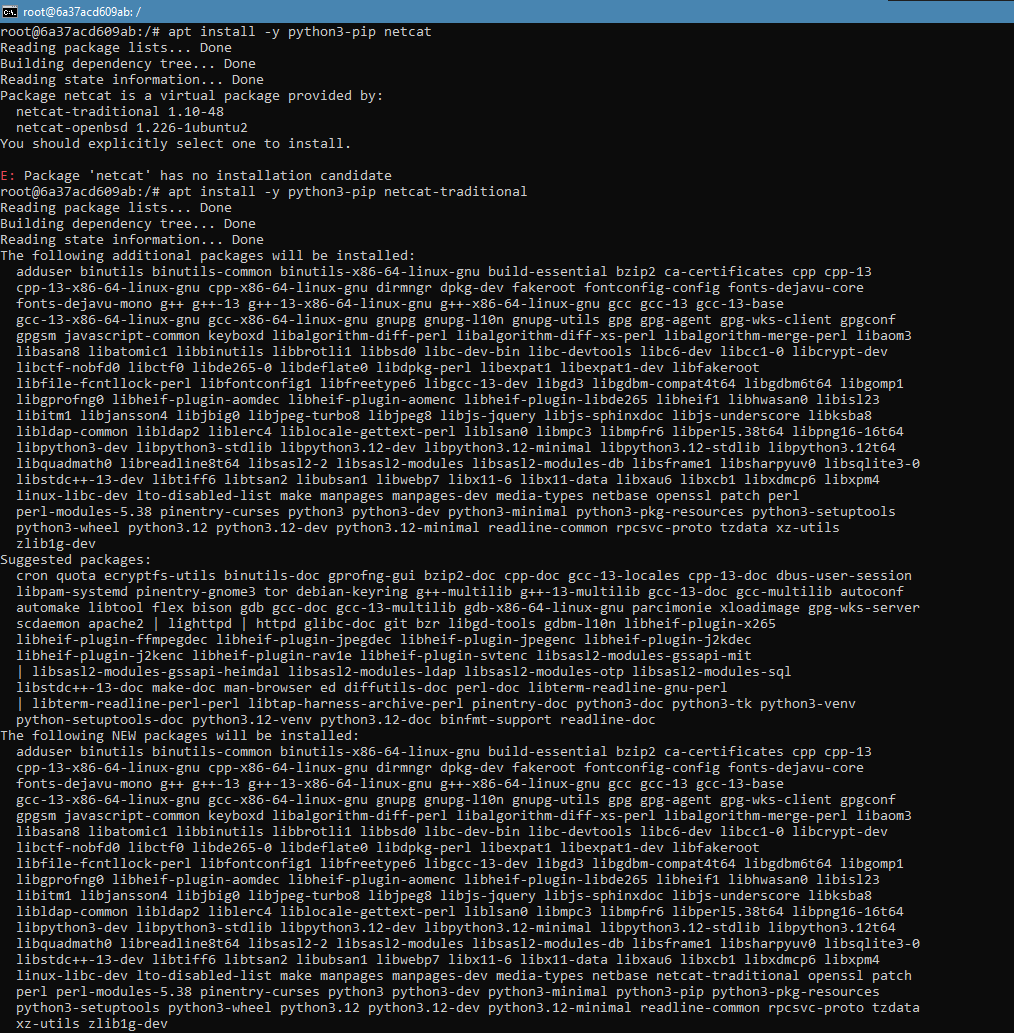

*(Nota:Con el comando ``dkpg-l | grep python3-pip`` y ``dkpg-l | grep python3-netcat``podremos ver si se ha instalado correctamente tanto la lista de paquetes pip *``(dkpg-l | grep python3-pip)``*, como el netcat *``(dkpg-l | grep python3-netcat)``*)*
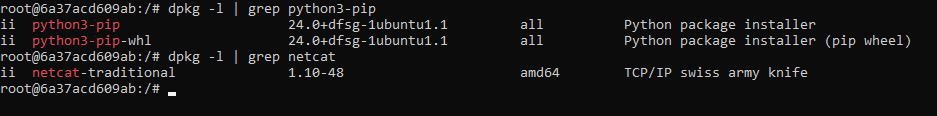

### 4.3 Instalar un entorno virtual (`venv`).
*       apt install -y python3-venv

### 4.4 Crear y Activar el Entorno Virtual
* Crear el entorno virtual llamado 'myvenv'

        python3 -m venv myvenv
* Activar el entorno virtual

        source myvenv/bin/activate
### 4.5 Instalar `cqlsh` dentro del entorno virtual activo
*       pip install cqlsh

*(Nota: Si encontraras errores de compilación aquí, necesitarías instalar antes `apt install -y build-essential python3-dev` fuera del `venv`, luego reactivar el `venv` e intentar `pip install cqlsh` de nuevo. En `ubuntu:latest`, las dependencias comunes de compilación para `cqlsh` suelen estar cubiertas o no son necesarias en el `venv`.)*

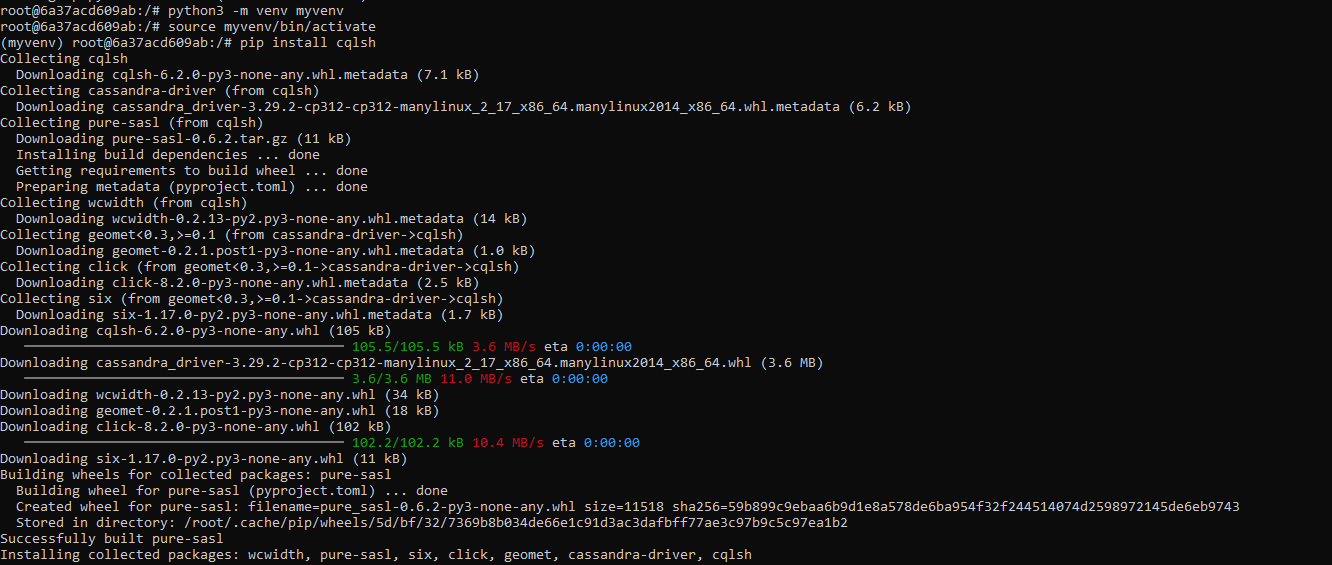

### 4.6 Conectar a Cassandra desde el entorno virtual activo en devbox
*       cqlsh cassandra 9042

*(Nota: Si la conexión es exitosa, verás el prompt `cqlsh>`. El nombre del host `cassandra` es reconocido porque ambos contenedores están en la misma red de Docker (`my_network`).*

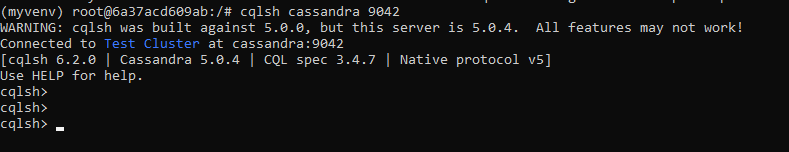



#BIGQUERY
## **Memoria del Trabajo: Análisis de Datos de Música con BigQuery**
##### **Objetivo**

El objetivo de este trabajo es realizar un análisis de datos utilizando BigQuery, enfocado en la música, específicamente en el análisis de la popularidad y características como la bailabilidad de las canciones a lo largo de los años. A través de consultas SQL complejas y el uso de funciones analíticas de BigQuery, se busca obtener una visión clara sobre las tendencias de la música en términos de popularidad y características musicales clave.


## **Descripción del Dataset**
El dataset proporcionado contiene información sobre canciones de listas de reproducción desde **2010 hasta 2022**, con campos como:

* **Año (year)**: Año de lanzamiento de la canción.

* **Nombre de la canción (track_name)**: El nombre de la canción.

* **Nombre del artista (artist_name)**: El nombre del artista de la canción.

* **Popularidad (track_popularity)**: Índice de popularidad de la canción.

* **Bailabilidad (danceability)**: Mide qué tan bailable es la canción, con valores entre 0 y 1.


## **Consultas Realizadas**
### **1. Análisis de la Popularidad Anual**
Para entender cómo ha cambiado la popularidad de la música a lo largo de los años, se realizó una consulta que calcula el promedio de popularidad por año y el cambio anual comparando con el año anterior.

```text
WITH popularidad_anual AS (
    SELECT
        year,
        AVG(track_popularity) AS promedio_popularidad
    FROM `tu_proyecto.tu_dataset.playlist_data`
    GROUP BY year
)
SELECT
    year,
    promedio_popularidad,
    LAG(promedio_popularidad) OVER (ORDER BY year) AS popularidad_anterior,
    promedio_popularidad - LAG(promedio_popularidad) OVER (ORDER BY year) AS cambio_anual
FROM popularidad_anual
ORDER BY year;
```
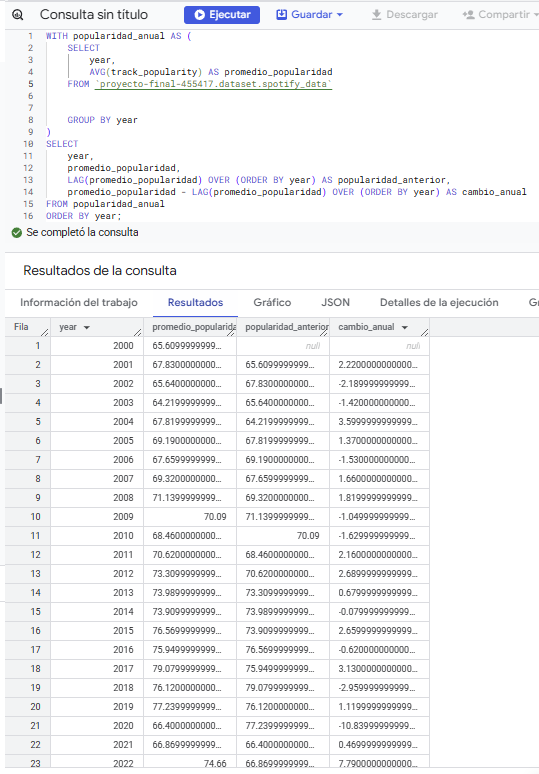

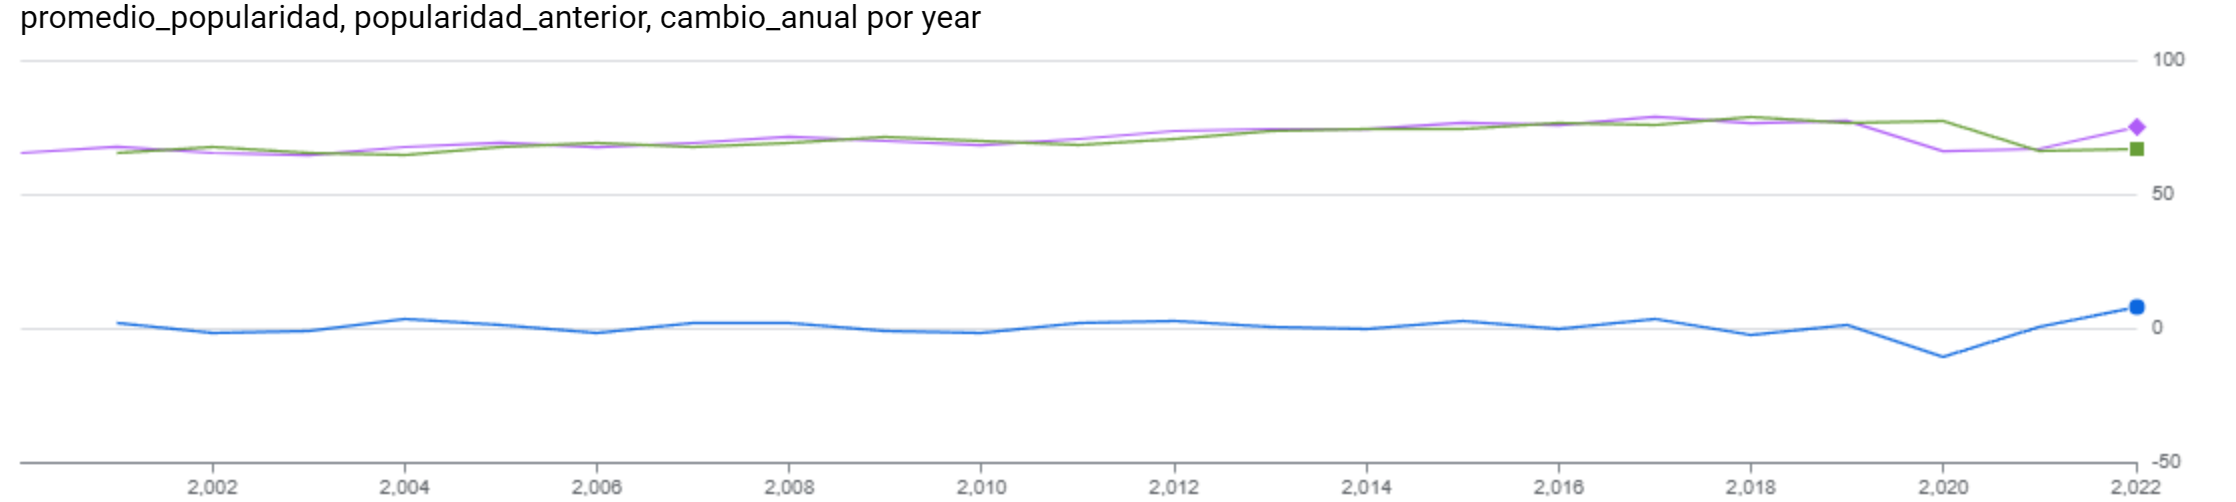

### Resultados y conclusiones:

* La popularidad de la música aumentó constantemente desde **2011 hasta 2017**.

* En **2018 y 2020** hubo caídas significativas, especialmente en **2020**, debido posiblemente a la pandemia de COVID-19.

* En **2022**, se produjo una gran recuperación en la popularidad.

## 2. Análisis de la Canción Más Bailable por Año
Utilizando la función **RANK()** de BigQuery, identificamos las canciones más bailables de cada año, basándonos en el valor de **danceability**. Se hizo una clasificación y se extrajo solo la canción más bailable por cada año.

```text
WITH top_danceability AS (
    SELECT
        year,
        track_name,
        artist_name,
        danceability,
        RANK() OVER (PARTITION BY year ORDER BY danceability DESC) AS ranking
    FROM `tu_proyecto.tu_dataset.playlist_data`
    WHERE danceability IS NOT NULL
)
SELECT
    year,
    track_name,
    artist_name,
    danceability
FROM top_danceability
WHERE ranking = 1
ORDER BY year;
```
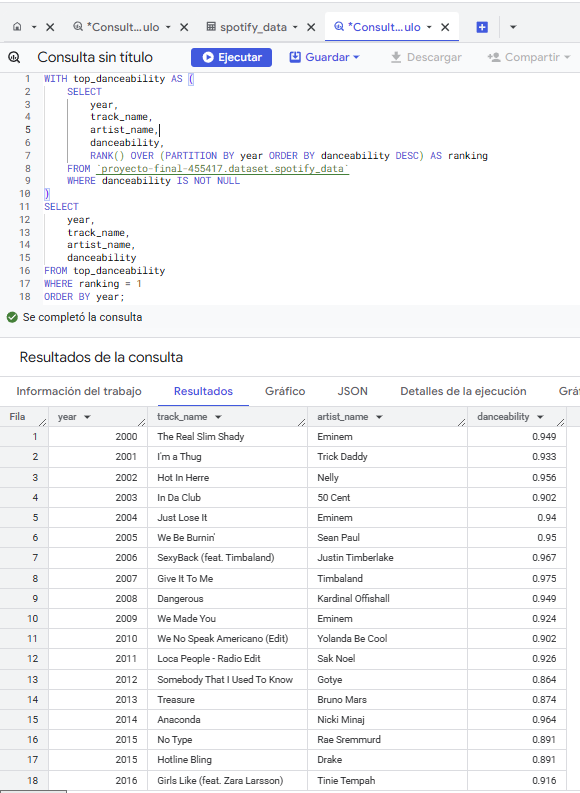

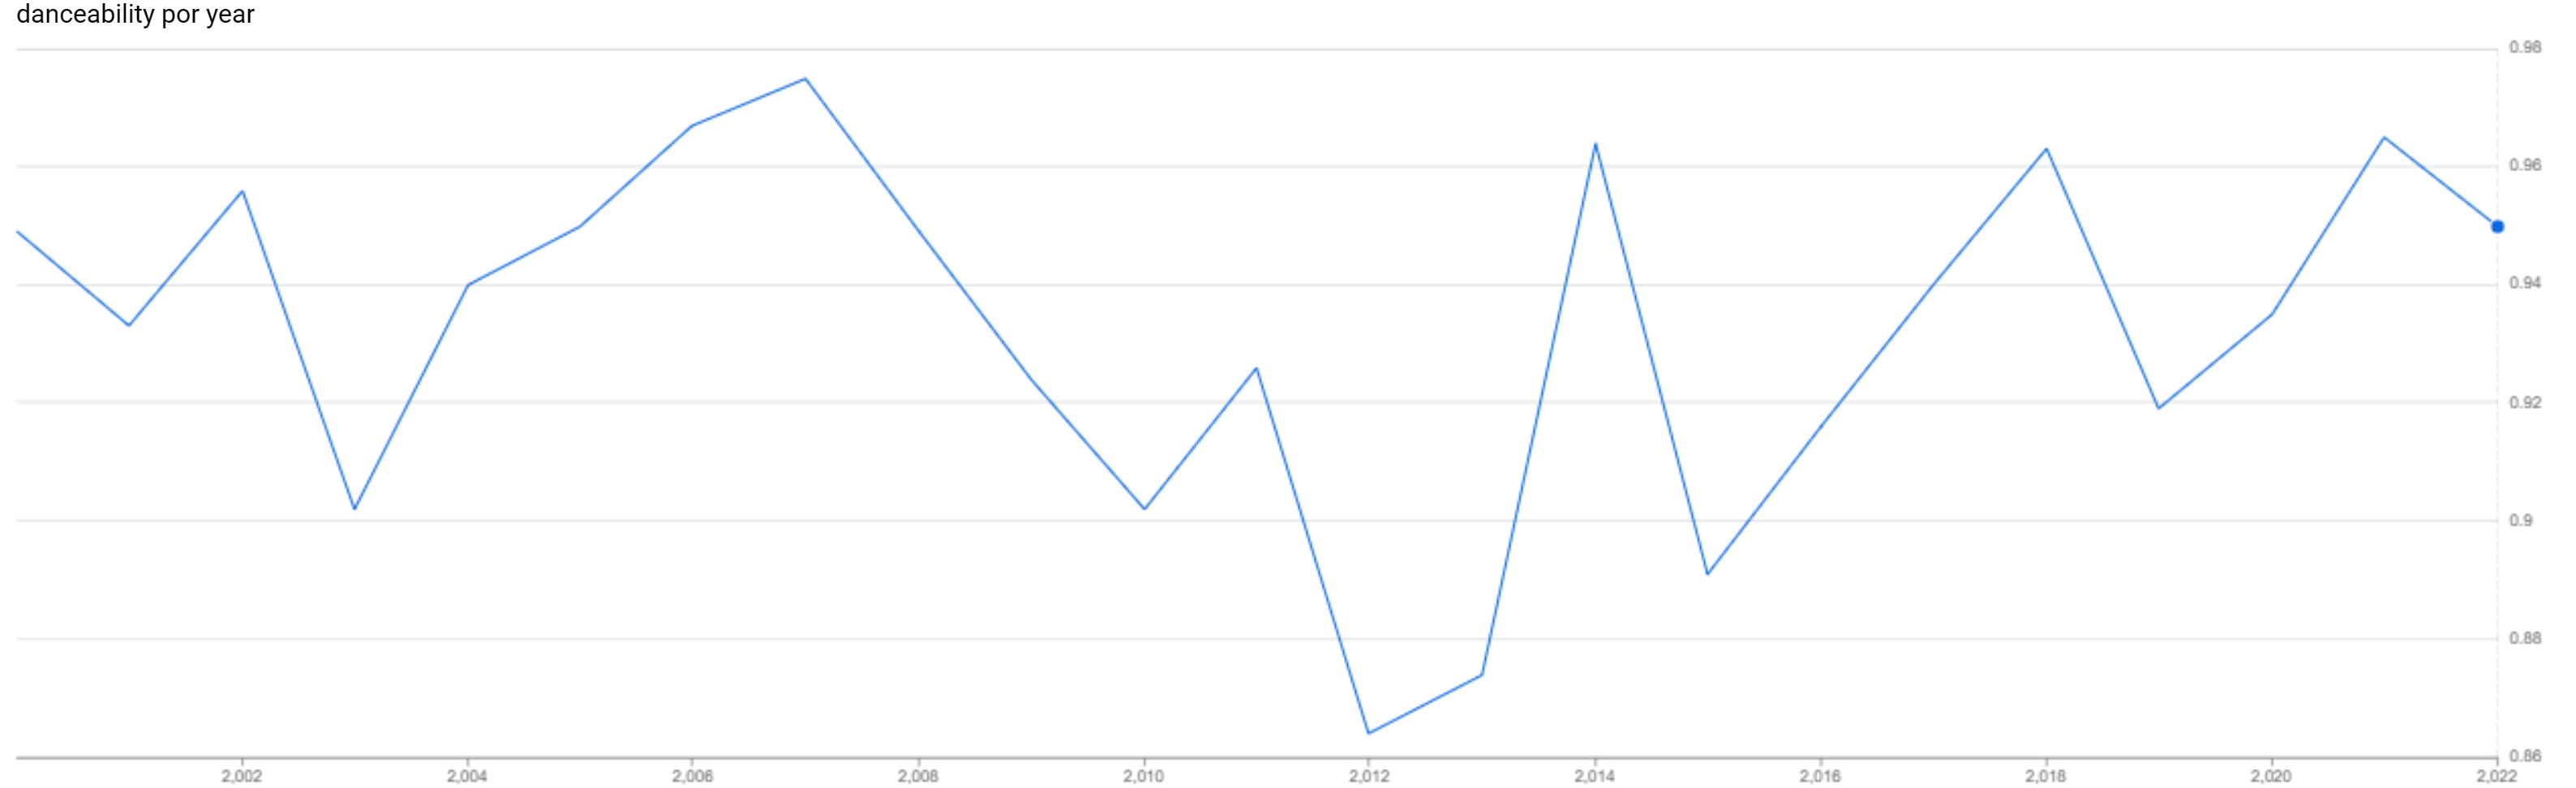

### Resultados y conclusiones:

Este análisis permite identificar cómo ha cambiado la "bailabilidad" de las canciones año tras año.

Se pueden observar tendencias como el aumento de canciones con mayor danceability en años recientes, especialmente en géneros como el reguetón y el K-pop.

# Conclusiones Generales
* **Tendencias de Popularidad**: A lo largo de los años, se observa que la música tuvo un crecimiento en popularidad, pero sufrió una gran caída en 2020, lo cual podría explicarse por la pandemia que afectó las actividades relacionadas con la música, como conciertos y festivales.

* **Bailabilidad**: La música más bailable cambió con los años. Aunque los géneros más bailables fueron predominantes en años recientes, las características de danceability en las canciones están fuertemente influenciadas por los cambios en las plataformas de música (como TikTok), y la variedad de géneros como reguetón, pop, y K-pop.

* **Impacto de la Pandemia**: La caída en popularidad y la reducción en la bailabilidad en 2020 reflejan los efectos de la pandemia, que alteraron el comportamiento de consumo de música a nivel mundial.



# **📝Proyecto de Obtención de Letras de Canciones (2000–2022)**

**🎯 Objetivo del Proyecto**

El objetivo fue automatizar la obtención de letras de canciones desde archivos CSV de playlists (2000-2022). Para construir un dataset completo y fiable, se combinaron el uso de la API pública lyrics.ovh y técnicas de web scraping en la página letras.com, empleando múltiples fuentes y estrategias. Todo esto esta dividido en 3 partes o codigos que complementan a todo este apartado de obtencion de letras de canciones

📁 **Archivos involucrados**  
* `playlist_2010to2022.csv` - Dataset original con canciones y artistas
* `canciones_con_letras.csv` - Salida con canciones + letras encontradas vía API
* `letras_no_encontradas.csv` - Canciones sin letra tras intentar con API
* `urls_letrascom.csv` - URLs encontradas en letras.com para scraping
* `urls_letrascom_cleaned.csv` - URLs limpias y preparadas para scraping
* `letras_com_scrapeadas_corregido.csv` - Letras finales obtenidas vía scraping

## 🔧 Código 1: "Obtención de letras usando la API pública lyrics.ovh"
**📌 Función principal:**

Utiliza la API pública `lyrics.ovh` para obtener letras automáticamente a partir de artista + título.

**⚙️ Descripción del funcionamiento:**

1.  Carga el CSV original.
    
        df = pd.read_csv(INPUT_CSV_FILE)


2. Verifica que tenga las columnas necesarias.

        if 'track_name' not in df.columns or 'artist_name' not in df.columns:
        print(f"❌ Error: El CSV debe contener las columnas 'track_name' y 'artist_name'.")
        exit(1)

3. Recorre canción por canción:
    
        for i, row in tqdm(tracks.iterrows(), total=len(tracks), desc="🔍 Procesando canciones"):
        title = row['track_name']
        artist = row['artist_name']

        ...

        lyrics = get_lyrics_from_lyrics_ovh(artist, title)

4. Llamar a la propia API bajo el nombre **`https://api.lyrics.ovh/v1/{artist}/{title}`**.

        def get_lyrics_from_lyrics_ovh(artist, title):
        try:
        response = requests.get(f"https://api.lyrics.ovh/v1/{artist}/{title}")
        ...



5. En el caso de que no encuentre la letra, la guarda. Si no, almacena el título en una lista para intentar más adelante con scraping.

        if lyrics:
        tracks.at[i, 'lyrics'] = lyrics.strip()
        else:
        print(f"❌ Letras no encontradas para: {title}")
        no_lyrics_list.append({'track_name': title, 'artist_name': artist})


### 🟢 Resultado:
Letras disponibles: se guardan en **`canciones_con_letras.csv.`**

Letras no encontradas: se guardan en **`letras_no_encontradas.csv.`**

### ⚠️ Errores detectados:
* Muchos títulos/artistas no devuelven letras por errores de formato (tildes, caracteres especiales).

* La API tiene resultados inconsistentes y no reconoce bien artistas internacionales o en español.

* Se incluyó **`time.sleep(2)`** entre peticiones para evitar bloqueos.


## 🔧 Código 2: "Web Scraping en letras.com para extracción de letras de canciones"
**📌 Función principal:**

Busca URLs de canciones en `letras.com` para aquellas que no pudieron obtenerse con la API.

**⚙️ ¿Cómo lo hace?**

1. Intenta una URL directa generando un slug (formato URL amigable) del artista y la canción.

        def slugify(text):
        text = text.lower()
        text = re.sub(r'[^\w\s-]', '', text)
        text = re.sub(r'[\s_-]+', '-', text)
        return text

        direct_url_path = f"/{slugify(artist_name)}/{slugify(track_name)}/"
        direct_url = f"{base_url}{direct_url_path}"


2. 2. Si la URL directa no existe, realiza una búsqueda en el sitio utilizando la estructura ***``https://www.letras.com/buscar/{track_name + artist_name}``***

           search_base_url = "https://www.letras.com/buscar/"
            query = f"{track_name} {artist_name}"
            encoded_query = quote(query)
            search_url = f"{search_base_url}{encoded_query}"


3. Extrae la primera URL válida del resultado de búsqueda (`<a class="song-name">`).

        soup = BeautifulSoup(response.content, 'html.parser')
        resultado = soup.find('a', class_='song-name')
        if resultado and 'href' in resultado.attrs:
        return f"{base_url}{resultado['href']}"

4. Guarda la URL en **``urls_letrascom.csv.``**

        df_resultados = pd.DataFrame(resultados_busqueda)
        df_resultados.to_csv('urls_letrascom.csv', index=False, encoding='utf-8')


### ✅ Resultado:
Obtiene una buena cantidad de URLs válidas de letras no encontradas anteriormente, que más tarde, podremos usar para hacer scrapling utlizando esta misma página web.

### ⚠️ Errores y ajustes:
* Algunos nombres no generaban slugs válidos → se creó función slugify.

* El scraping directo de los resultados requería un user-agent realista.

* Se evitó Selenium (aunque se valoró), ya que:

* Aumentaba complejidad.

* No era necesario para páginas simples como letras.com.

* El HTML podía manejarse con requests + BeautifulSoup.

## 🔧 Código 3: "Integración y manejo de datos: CSV de URLs y resultados de scraping"
**📌 Función principal:**

Accede a cada URL obtenida de letras.com y extrae el texto de la letra mediante scrapling.

**⚙️ ¿Cómo lo hace?**
1. Se accede con requests con un `user-agent` personalizado.

        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36     (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'
        }
        response = requests.get(url, headers=headers)

*(Nota:Esto es importante para evitar bloqueos o respuestas vacías por parte de letras.com.)*



2. Se usa BeautifulSoup para encontrar el `<div class="lyric-original">`, donde está la letra de la canción.

        soup = BeautifulSoup(response.content, 'html.parser')
        lyric_div = soup.find('div', class_='lyric-original')

*(Nota: Se intentó usar otras páginas como Genius, pero no fue viable porque las clases CSS de los contenedores eran dinámicas, lo que impedía extraer el contenido de forma estable.)*


3. Se limpian los espacios y se formatea el texto adecuadamente.

        letra_elements = lyric_div.find_all('p')
        letra = '\n'.join([p.get_text().strip() for p in letra_elements])


4. Guarda el resultado en letras_com_scrapeadas_corregido.csv.
df_resultados_letras.to_csv('urls_letrascom_cleaned.csv', index=False, encoding='utf-8')


### ⚠️ Problemas y soluciones:
    * Problemas	                      * Solución implementada
    Algunas letras no estaban en el HTML - Se detectó el mensaje "letra no disponible" y se omitió.
    HTML dinámico no cargado	         - Se descartó usar Selenium por simplicidad y eficiencia.
    Dificultades de codificación	     - Se forzó utf-8 y, como fallback, latin-1.
    Saltos de línea perdidos	         - Se usó .get_text(separator="\n", strip=True) para conservarlos.

### Resultado:
Se logró scrapear la mayoría de las letras restantes de forma efectiva, ampliando el dataset con información valiosa.

## 🧪 Herramientas Consideradas pero NO utilizadas

| Herramienta             | Motivo de descarte                                                                                                                               |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| Selenium                | Se consideró al principio para scrapear `letras.com` en caso de HTML dinámico. Pero al ser contenido estático y bien estructurado, no era necesario. Además, Selenium requería más dependencias, navegador, y era más lento. |
| APIs alternativas (Genius, Musixmatch, etc.) | Requieren autenticación (API key) y tienen límites estrictos o cobran. No eran viables para scraping automatizado sin riesgo de bloqueo. |
| Scrapy                  | Es potente, pero innecesario para la escala y simplicidad de este scraping. Se optó por `requests + BeautifulSoup` por ser más ligero.           |




# 🎶 Análisis de Letras de Canciones – Punto 2: Lenguaje y Estilo

Este análisis forma parte de un proyecto de NLP aplicado a letras de canciones. El objetivo del **Punto 2** es estudiar las propiedades lingüísticas básicas de las letras recopiladas en dos datasets distintos que se unificaron previamente.

---

## 📂 Estructura del dataset

- **letras_com_scrapeadas_corregido.csv**
- **canciones_con_letras.csv**

Ambos archivos fueron combinados para formar un solo corpus de letras. Las columnas relevantes fueron:

- `track_name`
- `artist_name`
- `lyrics`

---

## 🧼 Preprocesamiento realizado

1. Conversión de texto a minúsculas
2. Eliminación de puntuación y símbolos
3. Tokenización por espacios
4. Unión de los datasets

---

## 🔍 Análisis realizado

### 1. Palabras más comunes

Se analizaron las 20 palabras más frecuentes en el corpus total de letras. Las más comunes fueron:

- **you, i, me, love, know, like**, etc.

Estas palabras reflejan el estilo íntimo y emocional de muchas canciones, especialmente en géneros como el pop, R&B y baladas.

### 2. Riqueza léxica

Se calculó como:


- Valores bajos indican letras muy repetitivas.
- Valores altos indican diversidad de vocabulario.
- La mayoría de canciones tienen una riqueza entre **0.2 y 0.5**.

### 3. Longitud de las letras

- La longitud promedio se encuentra entre **200 y 400 palabras**.
- Muchas canciones cortas (<100 palabras) y algunas muy largas (>1000 palabras), lo que sugiere variedad de géneros o estilos.

---

## 📊 Visualizaciones generadas

- Gráfico de barras: top 20 palabras más comunes
- Histograma: distribución de riqueza léxica
- Histograma: distribución de longitud de las letras

---

## 📌 Conclusiones

- Las letras tienen un enfoque personal y emocional.
- Predomina un lenguaje informal.
- Hay gran variabilidad en longitud y riqueza, lo que sugiere mezcla de géneros.

---

> En la siguiente etapa (Punto 4), se procederá a extraer los **tópicos o temas comunes** presentes en las letras mediante técnicas de modelado de temas.



# 🎵 Análisis de Tópicos en Letras de Canciones por Género Musical – Punto 4

Este proyecto utiliza técnicas de modelado de tópicos (LDA) para analizar las letras de canciones y descubrir patrones temáticos dominantes asociados a distintos géneros musicales.

## 📌 Descripción

Se identificaron 5 tópicos dominantes a partir de las letras de canciones utilizando un modelo de LDA y se visualizó su distribución por género musical mediante un mapa de calor.

## 📁 Estructura del Proyecto

- `playlist_con_letras.csv`: Dataset base con información de canciones.
- `analisis_lda.py`: Script principal para análisis y visualización.
- `memoria.txt`: Documento con interpretación detallada y conclusiones del análisis.

## 🧪 Tecnologías

- Python
- Pandas, Numpy, Matplotlib, Seaborn, Scikit-learn, NLTK

## 📊 Resultados

- Asociación clara entre ciertos tópicos y géneros (ej. Trap Latino con temáticas urbanas).
- Detección de diferencias entre letras en español e inglés.
- Utilidad para clasificación musical, análisis de audiencias y sistemas de recomendación.

## 📚 Referencias

- LDA: Latent Dirichlet Allocation (Blei et al., 2003)
- Dataset: Letras y géneros extraídos desde una playlist de Spotify



# 🎶 Análisis de Letras de Canciones – Punto 6: Frecuencia y Similitud

Este proyecto utiliza Python y diversas bibliotecas de análisis de datos y visualización para explorar un conjunto de datos de letras de canciones. Realiza análisis de frecuencia de palabras y calcula la similitud léxica entre diferentes canciones y artistas.

## Características Principales

* **Análisis de Frecuencia de Palabras:**
    * Compara las palabras más utilizadas por un artista angloparlante (Taylor Swift) y un artista hispanohablante (Bad Bunny).
    * Analiza la evolución de las palabras más frecuentes en las letras de Coldplay a lo largo de dos décadas (2000s vs. 2010s).
* **Análisis de Similitud de Letras:**
    * Calcula y visualiza la similitud (usando TF-IDF y similitud del coseno) entre letras de 10 canciones de artistas diversos.
    * Calcula y visualiza la similitud entre letras de canciones pertenecientes a un mismo género musical (Pop).
* **Limpieza de Texto:** Incluye un preprocesamiento de las letras para normalizar el texto, eliminar caracteres no alfabéticos y filtrar stopwords en inglés y español.

## Requisitos Previos

* Python 3.x
* Las siguientes bibliotecas de Python:
    * `pandas`
    * `matplotlib`
    * `seaborn`
    * `scikit-learn`
    * `collections` (generalmente viene con Python estándar)
    * `re` (generalmente viene con Python estándar)
* Un archivo de datos llamado `playlist_con_letras.csv` en el mismo directorio que el script.

## Estructura del Archivo de Datos (`playlist_con_letras.csv`)

El archivo CSV debe contener al menos las siguientes columnas:

* `artist_name`: Nombre del artista.
* `track_name`: Nombre de la canción.
* `lyrics`: Letra de la canción.
* `year`: Año de lanzamiento de la canción (para el análisis de Coldplay).

## Instalación

1.  Asegúrate de tener Python 3 instalado.
2.  Clona este repositorio o descarga los archivos.
3.  Instala las bibliotecas necesarias. Puedes hacerlo usando pip:

    ```bash
    pip install pandas matplotlib seaborn scikit-learn
    ```

## Uso

1.  Coloca tu archivo `playlist_con_letras.csv` en el mismo directorio que el script de Python.
2.  Ejecuta el script desde tu terminal:

    ```bash
    python tu_script.py
    ```

    (Reemplaza `tu_script.py` con el nombre real de tu archivo Python).

3.  El script generará y mostrará varios gráficos como salida.

### Salidas Esperadas (Visualizaciones)

A continuación se describe qué gráficos se generan y dónde irían las imágenes si las añadieras a este README.

1.  **Análisis de Frecuencia: Taylor Swift vs. Bad Bunny**
    * Descripción: Dos diagramas de barras mostrando las 15 palabras más frecuentes para Taylor Swift y Bad Bunny, respectivamente, después de la limpieza y eliminación de stopwords.
    * *Aquí podrías insertar una imagen del gráfico:*
        `![Frecuencia de Palabras: Taylor Swift vs. Bad Bunny](ruta/a/imagen_frecuencia_taylor_badbunny.png)`

2.  **Análisis de Frecuencia: Coldplay por Décadas**
    * Descripción: Dos diagramas de barras mostrando las 15 palabras más frecuentes en las canciones de Coldplay de la década de 2000 y la década de 2010.
    * *Aquí podrías insertar una imagen del gráfico:*
        `![Frecuencia de Palabras: Coldplay 2000s vs 2010s](ruta/a/imagen_frecuencia_coldplay_decadas.png)`

3.  **Similitud entre Letras (Artistas Diferentes)**
    * Descripción: Un mapa de calor (heatmap) que muestra la similitud del coseno entre las letras de 10 canciones seleccionadas aleatoriamente de artistas diferentes.
    * *Aquí podrías insertar una imagen del heatmap:*
        `![Similitud Letras: Artistas Diversos](ruta/a/imagen_similitud_diversos.png)`

4.  **Similitud entre Letras (Mismo Género - Pop)**
    * Descripción: Un mapa de calor (heatmap) que muestra la similitud del coseno entre las letras de varias canciones seleccionadas del género Pop.
    * *Aquí podrías insertar una imagen del heatmap:*
        `![Similitud Letras: Género Pop](ruta/a/imagen_similitud_pop.png)`

## Personalización

* **Artistas para Análisis de Frecuencia:** Puedes cambiar los artistas en la lista `artists_to_compare` en la sección 1 del script.
* **Artistas para Análisis de Género:** Modifica la lista `pop_artists_list` en la sección 4 para incluir diferentes artistas del género que desees analizar, o cambia el género por completo.
* **Número de Palabras/Canciones:** Ajusta el número de palabras más comunes (`most_common(15)`) o el número de canciones en las muestras (`sample(10)`) según tus necesidades.
* **Stopwords:** Puedes expandir las listas `basic_stopwords_en` y `basic_stopwords_es` si identificas más palabras comunes que deseas excluir del análisis.

---

# 🎶 Análisis de Letras de Canciones – Punto 7: Tendencias y Contexto Social

Este análisis forma parte de un proyecto de NLP aplicado a letras de canciones. El **Punto 7** examina cómo eventos sociales relevantes (como la pandemia de COVID-19) y factores lingüísticos (idioma del artista) se reflejan en el contenido lírico.

---

## 📂 Estructura del Dataset

- `playlist_con_letras.csv`

Columnas clave:
- `artist_name`: Nombre del artista
- `track_name`: Nombre de la canción
- `lyrics`: Letra completa
- `year`: Año de lanzamiento

---

## 🧼 Preprocesamiento realizado

1. Conversión a minúsculas  
2. Eliminación de signos de puntuación y caracteres no alfabéticos  
3. Normalización de contracciones  
4. Tokenización  
5. Eliminación de stopwords (en inglés y español)

---

## 🔍 Análisis realizado

### 1. Impacto de la Pandemia de COVID-19 🦠

Comparativa de frecuencia relativa de palabras clave entre dos periodos:

- **Antes de la pandemia**: 2017–2019  
- **Durante la pandemia**: 2020–2022

📌 Hallazgos principales:
- **Incremento notorio** de términos como: `virus`, `covid`, `pandemia`, `mascarilla`, `confinamiento`, `distancia`.
- **Temas emocionales y personales** más presentes: `casa`, `solo`, `miedo`, `salud`, `esperanza`.
- **Mayor expresión en español** para términos sanitarios, como `mascarilla` y `confinamiento`.

📊 Visualización:
- Gráfico de barras de frecuencias relativas (ej. `image_c58441.png`)  
  `![Impacto de la Pandemia en Letras](ruta/a/tu/image_c58441.png)`

---

### 2. Comparativa Lingüística: Hispanohablantes vs. Angloparlantes 🗣️

Análisis basado en la agrupación manual de artistas según idioma predominante.

📌 Hallazgos principales:

- **Code-switching** en artistas hispanohablantes:  
  Palabras como `baby`, `like`, `love`, `one`, `theres` aparecen con alta frecuencia en letras en español.

- **Vocabularios representativos**:  
  - **Angloparlantes**: `like`, `love`, `got`, `baby`, `time`, `never`, `ooh`  
  - **Hispanohablantes**: `quiero`, `bien`, `dura`, `contigo`, `mami`, `corazón`, `noche`, `uoh`

- **Diferencia en tamaño de corpus**:  
  El corpus en inglés fue notablemente más grande que el de español, lo que puede influir en la diversidad léxica observada.

---

## 🧪 Metodología

- Herramientas utilizadas:
  - `Python`, `Pandas`, `NLTK`, `Matplotlib`, `Seaborn`
- Técnicas:
  - Cálculo de frecuencias relativas (por cada 10,000 palabras)
  - Extracción de n-gramas
  - Visualización comparativa por periodo o grupo

---

## 📌 Conclusiones

- Las letras reflejan cambios sociales importantes: la pandemia se manifiesta explícitamente en el lenguaje.
- El **code-switching** (uso de inglés en letras en español) es común entre artistas hispanos contemporáneos.
- A pesar de diferencias culturales y lingüísticas, **temas universales como el amor** siguen predominando en ambos grupos.
- El análisis de letras musicales ofrece una ventana cuantitativa a **tendencias culturales y sociales** en la música popular.

---


